# Assignment 10: Review

We will review material covered so far in this course with short questions similar to what you might expect on the Final Exam. 

First review the lecture notes. Then try to do this assignment without referring to ANY external material to simulate exam conditions.

Setup for Q1

In [1]:
%load_ext sql

In [2]:
import pandas as pd
import numpy as np

In [3]:
from collections import OrderedDict

In [4]:
pid = ['a', 'c', 'a', 'b', 'c', 'a', 'c', 'c', 'a', 'a', 'b', 'b']
visit = [1, 1, 2, 1, 2, 3, 3, 4, 4, 5, 2, 3]
n = len(pid)

readings = pd.DataFrame(OrderedDict(pid=pid, visit=visit, sbp=np.random.normal(120, 25, n)))
readings['dbp'] = readings.sbp - np.random.normal(40, 10, n)

In [5]:
readings[['sbp', 'dbp']] = readings[['sbp', 'dbp']].astype('int')

In [6]:
patients = pd.DataFrame(OrderedDict(pid=['a', 'b', 'c', 'd'], ages=[23,34,45,56]))

In [7]:
%sql sqlite:///tables.db

'Connected: @tables.db'

In [8]:
%sql drop table patients
%sql persist patients

 * sqlite:///tables.db
Done.
 * sqlite:///tables.db


'Persisted patients'

In [9]:
%sql drop table readings
%sql persist readings

 * sqlite:///tables.db
Done.
 * sqlite:///tables.db


'Persisted readings'

In [10]:
%%sql

select * from patients

 * sqlite:///tables.db
Done.


index,pid,ages
0,a,23
1,b,34
2,c,45
3,d,56


In [11]:
%%sql 

select * from readings

 * sqlite:///tables.db
Done.


index,pid,sbp,visit,dbp
0,a,164,1,129
1,c,134,1,112
2,a,135,2,98
3,b,118,1,74
4,c,115,2,62
5,a,96,3,65
6,c,169,3,128
7,c,117,4,74
8,a,87,4,39
9,a,119,5,94


**1**. (20 points)

- Write an SQL statement to merge the patient and pressure tables using an inner join
- Write an SQL statement to find the average systolic (sbp) and diastolic (dbp) blood pressure for each patient, sorted in ascending order of sbp. The function to calculate averages in SQL is AVG.
- (optional - ungraded) Write an SQL statement to find the running average of systolic blood pressure for each patient across successive visits. Show the following columns pid, visit, sbp and running average of sbp. (NOTE: This will no work unless you have the version 3.2.5 or higher of SQLite3 or swithc to a database like PostgreSQL - in particular, it will not work on Docker. Just write the SQL even if it does not execute.)

In [12]:
%%sql

SELECT * 
FROM patients INNER JOIN readings ON patients.pid=readings.pid;

 * sqlite:///tables.db
Done.


index,pid,ages,index_1,pid_1,sbp,visit,dbp
0,a,23,0,a,164,1,129
0,a,23,2,a,135,2,98
0,a,23,5,a,96,3,65
0,a,23,8,a,87,4,39
0,a,23,9,a,119,5,94
1,b,34,3,b,118,1,74
1,b,34,10,b,126,2,72
1,b,34,11,b,107,3,64
2,c,45,1,c,134,1,112
2,c,45,4,c,115,2,62


In [13]:
%%sql
SELECT pid,AVG(sbp),AVG(dbp) 
FROM readings
GROUP BY pid
ORDER BY AVG(sbp);

 * sqlite:///tables.db
Done.


pid,AVG(sbp),AVG(dbp)
b,117.0,70.0
a,120.2,85.0
c,133.75,94.0


In [14]:
%%sql

SELECT pid,visit,sbp,
        AVG(sbp) OVER win AS running average of sbp
FROM readings
WINDOW win AS (PARTITION BY pid ORDER BY visit);

 * sqlite:///tables.db
(sqlite3.OperationalError) near "win": syntax error [SQL: 'SELECT pid,visit,sbp,\n        AVG(sbp) OVER win AS running average of sbp\nFROM readings\nWINDOW win AS (PARTITION BY pid ORDER BY visit);'] (Background on this error at: http://sqlalche.me/e/e3q8)


**2**. (30 points)

- Use a raw count bag of words model for unigrams and bigrams to generate feature vectors for these two documents. For simplicity, you may tokenize by removing punctuation, splitting by white space to find words, and converting all words to lowercase. 
- Implement a function to calculate cosine *similarity* between two vectors without using any trigonometric functions, built-in distance functions or linear algebra modules. Find the cosine similarity between the two documents. Recall that the cosine similarity is the dot product of two unit vectors.

Only use the Python standard library and `numpy` to do this exercise.

In [15]:
doc1 = """As I was going by Charing Cross,
I saw a black man upon a black horse;
They told me it was King Charles the First-
Oh dear, my heart was ready to burst!"""

doc2 = """As I was going to St. Ives,
I met a man with seven wives,
Each wife had seven sacks,
Each sack had seven cats,
Each cat had seven kits:
Kits, cats, sacks, and wives,
How many were there going to St. Ives"""

In [16]:
def unigram(doc):
    ans=[]
    for word in doc.lower().split():
        ans.append(word.strip(', ;-!.:'))
    return ans

In [17]:
doc1_word=unigram(doc1)
doc2_word=unigram(doc2)

In [18]:
def vectorize(doc1_word,doc2_word):
    words=list(set(doc1_word+doc2_word))
    n=len(words)
    vec1=np.zeros(n)
    vec2=np.zeros(n)
    for i in range(n):
        vec1[i]=doc1_word.count(words[i])
        vec2[i]=doc2_word.count(words[i])
    return vec1,vec2

In [19]:
def cosine_distance(vec1,vec2):
    return np.sum(vec1*vec2)/((np.sum(vec1**2)**0.5)*np.sum(vec2**2)**0.5)

In [20]:
vec1_unigram=vectorize(doc1_word,doc2_word)[0]
vec2_unigram=vectorize(doc1_word,doc2_word)[1]
cosine_distance(vec1_unigram,vec2_unigram)

0.2439750182371333

In [21]:
def bigram(unigrams):
    ans=[]
    for i in range(len(unigrams)-1):
        ans.append(unigrams[i]+' '+unigrams[i+1])
    return ans

In [22]:
doc1_bi=bigram(doc1_word)
doc2_bi=bigram(doc2_word)
vec1_bigram=vectorize(doc1_bi,doc2_bi)[0]
vec2_bigram=vectorize(doc1_bi,doc2_bi)[1]
cosine_distance(vec1_bigram,vec2_bigram)

0.07067142711473183

**3**. (30 points)

- Fit polynomials of order 2, 3 and 4 to the data set `x` and `y` by solving the normal equations $(X^TX) \hat{\beta} = X^Ty$. 
- Plot the fit against the data for each model.
- Calculate the sum of squares error for each model using leave one out cross-validation.

You may use `numpy.linalg` for this.

In [23]:
x = np.array([4.17022005e+00, 7.20324493e+00, 1.14374817e-03, 3.02332573e+00,
       1.46755891e+00, 9.23385948e-01, 1.86260211e+00, 3.45560727e+00,
       3.96767474e+00, 5.38816734e+00])
y = np.array([29.05627699, 22.38450486,  3.33047527, 23.84338844, 16.98396787,
        9.32107716, 17.8343173 , 25.23079674, 28.068074  , 26.74943485])

In [24]:
#order 2
import numpy.linalg as la
x2=np.c_[np.ones(len(x)),x,x**2]
beta2=la.solve((x2.T@x2),(x2.T@y))
beta2

array([ 2.48779865, 10.49340176, -1.07498928])

In [25]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x,y)
x2_plot = np.linspace(-2, 10, 100)
y2_plot = beta2[0]+beta2[1]*x2_plot+beta2[2]*x2_plot**2
plt.plot(x2_plot,y2_plot)
plt.show()

<Figure size 640x480 with 1 Axes>

In [26]:
def sumSquareError(x,y,order):
    ans=0
    for i in range(len(x)):
        tempx =np.delete(x,i)
        tempy =np.delete(y,i)
        xPoly = np.c_[np.ones(len(tempx)),tempx]
        test_x = np.c_[np.ones(1),x[i]]
        for o in range(2,order+1):
            xPoly = np.c_[xPoly,tempx**o]
            test_x = np.c_[test_x,x[i]**o]
        beta=la.solve((xPoly.T@xPoly),(xPoly.T@tempy))
        #print(beta)
        #print(test_x.shape)
        y_pred=test_x@beta
        ans+=(y_pred-y[i])**2
    return ans[0]

In [27]:
sumSquareError(x,y,2)

22.22130709444697

In [28]:
#order 3
x3=np.c_[np.ones(len(x)),x,x**2,x**3]
beta3=la.solve((x3.T@x3),(x3.T@y))
beta3

array([ 2.75572438,  9.92576392, -0.86830902, -0.01892285])

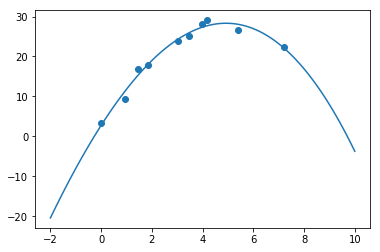

In [29]:
plt.figure()
plt.scatter(x,y)
x3_plot = np.linspace(-2, 10, 100)
y3_plot = beta3[0]+beta3[1]*x3_plot+beta3[2]*x3_plot**2+beta3[3]*x3_plot**3
plt.plot(x3_plot,y3_plot)
plt.show()

In [30]:
sumSquareError(x,y,3)

119.6352158884665

In [31]:
#order 4
x4=np.c_[np.ones(len(x)),x,x**2,x**3,x**4]
beta4=la.solve((x4.T@x4),(x4.T@y))
beta4

array([ 3.15172574,  7.80914918,  0.72437425, -0.39690615,  0.027373  ])

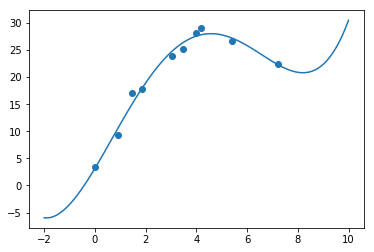

In [32]:
plt.figure()
plt.scatter(x,y)
x4_plot = np.linspace(-2, 10, 100)
y4_plot = beta4[0]+beta4[1]*x4_plot+beta4[2]*x4_plot**2+beta4[3]*x4_plot**3+beta4[4]*x4_plot**4
plt.plot(x4_plot,y4_plot)
plt.show()

In [33]:
sumSquareError(x,y,4)

510.60567208697984

**4** (20 points)

- Write a gradient descent algorithm to fit a cubic polynomial to the data from question 5. Use a learning rate of 1e-5 and 1 million iterations, and start with a $\beta_0 = (1,10,1,1)$
- Use a JIT decorator to create a compiled version and report the fold-change improvement in run time. Use the timeit.timeit function with argument `number=1`, and use a lambda function to pass in a function that takes 0 arguments.
- Plot the fitted curve

In [34]:
def gradientDescent(beta,X,y,learning_rate,iterations,m):
    for i in range(iterations):
        y_model = X@beta
        error = y_model-y
        gradient = (X.T@error)/m
        beta -= gradient*learning_rate
    return beta

In [35]:
beta=(1,10,1,1)
learning_rate=1e-5
iterations=1000000
X=np.c_[np.ones(len(x)),x,x**2,x**3]
m=len(x)
coeff = gradientDescent(beta,X,y,learning_rate,iterations,m)
coeff

array([ 2.50376948, 10.21338542, -0.95116202, -0.01223664])

In [36]:
from numba import jit
import timeit
@jit()
def gradientDescent_j(beta,X,y,learning_rate,iterations,m):
    for i in range(iterations):
        y_model = X@beta
        error = y_model-y
        gradient = (X.T@error)/m
        beta -= gradient*learning_rate
    return beta

In [54]:
if __name__=='__main__':
    from timeit import Timer
    t = Timer(lambda: gradientDescent(beta,X,y,learning_rate,iterations,m))
    print (t.timeit(number=1))
    tj = Timer(lambda: gradientDescent_j(beta,X,y,learning_rate,iterations,m))
    print (tj.timeit(number=1))

6.031384616158903
5.868742826394737


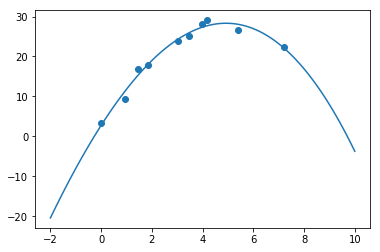

In [38]:
plt.figure()
plt.scatter(x,y)
x5_plot = np.linspace(-2, 10, 100)
y5_plot = coeff[0]+coeff[1]*x5_plot+coeff[2]*x5_plot**2+coeff[3]*x5_plot**3
plt.plot(x3_plot,y3_plot)
plt.show()